# Prepare hdf5 file starting from images stored in different directories 

This is an example of creating a hdf5 file which we took from a real application, meaning it might be more complicated then what you require in a more simple situation.

Here we have images corresponding to two classes: Class 0: Adeno, Class 1: Squamous.
Moreover we have 50 images per patient and each patient corresponds to one of these two labels.

In this example we have our images in 3 directories: CD1, CD2, training-pa129-188-8x.
In each of these directories we have several subdirectorise and the name of the subdirectory contains the class label, meaning we can use the sub-dir-name to extract the label. Moreover the name of the subdirectory contains also the patient number (pat_nr), which we also extract. Within each sub-dir we have the corresponding 50 images which have all the same label. 

Based on this information we create a pandas data frame with the following columns: path, pat_nr, label, Klasse (see below).

We then want to split the images of the patients in 2 sets - train and validation. Images from the same patient should be only in one of the two sets. Maybe you want to create 3 sets: train, validation, test.
We use the pat_nr-indices to split the data frame in 2 parts - train and validation - from which we get the path-info of the images and the corresponding labels. For train and validation seperately we read-in and resize all images and create an array. For train and validation seperately we create an array containing the corresoponding label-number (Klasse either 0 for adeno or 1 for squamous). For train and validation seperately, we then save the corresponding arrays in a train.hdf5 and val.hdf5 file.


In [1]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
import pandas as pd
import random
import glob
import os

In [2]:
import re
def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

### First get all folders and then all paths of the images, form that extract the pat_nr and the label

In [3]:
#List all folders in path and sort them
Ordner1=np.asarray(sorted(glob.glob("/notebooks/local/Patho_Poster_DLD_2017/CD1/*"), key=natural_key))
print(Ordner1[0])

Ordner2=np.asarray(sorted(glob.glob("/notebooks/local/Patho_Poster_DLD_2017/CD2/*"), key=natural_key))
print(Ordner2[0])

Ordner3=np.asarray(sorted(glob.glob("/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/*"), key=natural_key))
print(Ordner3[0])

/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa1
/notebooks/local/Patho_Poster_DLD_2017/CD2/sqcc-pa41
/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa129-adeno


In [4]:
Ordner=np.hstack((Ordner1,Ordner2,Ordner3))

In [5]:
print(Ordner[0:5])
print(Ordner[len(Ordner)-5:len(Ordner)])

['/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa1'
 '/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa2'
 '/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa3'
 '/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa4'
 '/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa5']
['/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa184-adeno'
 '/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa185-adeno'
 '/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa186-adeno'
 '/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa187-adeno'
 '/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa188-sqcc']


In [6]:
Pfade=np.empty(0)
for i in range(0,len(Ordner)):
    Pfade = np.append(Pfade,(sorted(glob.glob(Ordner[i]+"/*tif"), key=natural_key)))

In [7]:
print(Pfade[0:5])
print(Pfade[len(Pfade)-5:len(Pfade)])

['/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa1/adeno-pa1-im1.tif'
 '/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa1/adeno-pa1-im2.tif'
 '/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa1/adeno-pa1-im3.tif'
 '/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa1/adeno-pa1-im4.tif'
 '/notebooks/local/Patho_Poster_DLD_2017/CD1/adeno-pa1/adeno-pa1-im5.tif']
['/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa188-sqcc/sqcc-pa188-im46.tif'
 '/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa188-sqcc/sqcc-pa188-im47.tif'
 '/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa188-sqcc/sqcc-pa188-im48.tif'
 '/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa188-sqcc/sqcc-pa188-im49.tif'
 '/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa188-sqcc/sqcc-pa188-im50.tif']


In [8]:
Pfade.shape

(6950,)

In [9]:
print(Pfade[0].split("/")[5])
print(Pfade[3999].split("/")[5])
print(Pfade[4001].split("/")[5])

adeno-pa1
sqcc-pa80
pa129-adeno


### extracting labels

In [10]:
test=np.empty(len(Pfade),dtype="U30")
for i in range(0,len(Pfade)):
    test[i]=Pfade[i].split("/")[5]

In [11]:
test

array(['adeno-pa1', 'adeno-pa1', 'adeno-pa1', ..., 'pa188-sqcc',
       'pa188-sqcc', 'pa188-sqcc'], dtype='<U30')

In [12]:
label= np.empty(len(test),"U30")
for i in range(0,len(test)):
    if test[i].split("-")[0]=="adeno" or test[i].split("-")[1]=="adeno":
          label[i]="adeno"
    if test[i].split("-")[0]=="sqcc" or test[i].split("-")[1]=="sqcc" :
              label[i]="sqcc"

In [13]:
label

array(['adeno', 'adeno', 'adeno', ..., 'sqcc', 'sqcc', 'sqcc'],
      dtype='<U30')

In [14]:
np.unique(label,return_counts=True)

(array(['adeno', 'sqcc'], dtype='<U30'), array([3800, 3150]))

### extracting pat_nr

In [15]:
Pat_nr=[re.sub("pa",repl="",string=test[idx]) for idx in range(0,len(test))]
Pat_nr=[re.sub("adeno",repl="",string=Pat_nr[idx]) for idx in range(0,len(test))]
Pat_nr=[re.sub("sqcc",repl="",string=Pat_nr[idx]) for idx in range(0,len(test))]
Pat_nr=[re.sub("-",repl="",string=Pat_nr[idx]) for idx in range(0,len(test))]

In [16]:
Pat_nr=np.array(Pat_nr,dtype="uint16")
print(Pat_nr[0:5])
print(Pat_nr[len(Pfade)-5:len(Pat_nr)])

[1 1 1 1 1]
[188 188 188 188 188]


### extracting label as number

In [17]:
Klasse=np.asarray(label=="sqcc",dtype="uint8")

### putting all together

In [18]:
np.shape(np.column_stack((Pfade,Pat_nr,label,Klasse)))

(6950, 4)

In [19]:
import pandas

In [20]:
Patho_data=pandas.DataFrame(data=np.column_stack((Pfade,Pat_nr,label,Klasse)),columns=["Pfad","Pat_nr","label","Klasse"])

In [21]:
Patho_data

,Pfad,Pat_nr,label,Klasse
0,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
1,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
2,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
3,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
4,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
5,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
6,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
7,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
8,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0
9,/notebooks/local/Patho_Poster_DLD_2017/CD1/ade...,1,adeno,0


In [22]:
np.transpose(np.unique(Pat_nr,return_counts=True))

array([[  1,  50],
       [  2,  50],
       [  3,  50],
       [  4,  50],
       [  5,  50],
       [  6,  50],
       [  7,  50],
       [  8,  50],
       [  9,  50],
       [ 10,  50],
       [ 11,  50],
       [ 12,  50],
       [ 13,  50],
       [ 14,  50],
       [ 15,  50],
       [ 16,  50],
       [ 17,  50],
       [ 18,  50],
       [ 19,  50],
       [ 20,  50],
       [ 21,  50],
       [ 22,  50],
       [ 23,  50],
       [ 24,  50],
       [ 25,  50],
       [ 26,  50],
       [ 27,  50],
       [ 28,  50],
       [ 29,  50],
       [ 30,  50],
       [ 31,  50],
       [ 32,  50],
       [ 33,  50],
       [ 34,  50],
       [ 35,  50],
       [ 36,  50],
       [ 37,  50],
       [ 38,  50],
       [ 39,  50],
       [ 40,  50],
       [ 41,  50],
       [ 42,  50],
       [ 43,  50],
       [ 44,  50],
       [ 45,  50],
       [ 46,  50],
       [ 47,  50],
       [ 48,  50],
       [ 49,  50],
       [ 50,  50],
       [ 51,  50],
       [ 52,  50],
       [ 53,

In [23]:
print(np.unique(Klasse,return_counts=True)[1]/50)
print("Pat")
print("adeno","sqcc")

[76. 63.]
Pat
adeno sqcc


In [24]:
np.unique(Pat_nr)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188], dtype=uint16)

### splitting into train and valid

In [25]:
np.random.seed(seed=278)
Pat_sample=np.sort(np.random.choice(np.unique(Pat_nr),28,replace=False))
Pat_sample

array([  1,   3,   6,  21,  24,  26,  35,  43,  46,  48,  51,  55,  56,
        64,  66,  78, 135, 137, 143, 147, 148, 152, 154, 160, 170, 179,
       186, 188], dtype=uint16)

In [26]:
val_dist=[Patho_data.loc[np.where(Pat_nr==Pat_sample[idx])[0][0],"label"] for idx in range(0,len(Pat_sample))]
val_dist=np.array(val_dist,dtype="U30")
print(val_dist)
np.unique(val_dist,return_counts=True)

['adeno' 'adeno' 'adeno' 'adeno' 'adeno' 'adeno' 'adeno' 'sqcc' 'sqcc'
 'sqcc' 'sqcc' 'sqcc' 'sqcc' 'sqcc' 'sqcc' 'sqcc' 'adeno' 'sqcc' 'adeno'
 'adeno' 'adeno' 'adeno' 'sqcc' 'adeno' 'sqcc' 'adeno' 'adeno' 'sqcc']


(array(['adeno', 'sqcc'], dtype='<U30'), array([15, 13]))

In [27]:
Pat_sample

array([  1,   3,   6,  21,  24,  26,  35,  43,  46,  48,  51,  55,  56,
        64,  66,  78, 135, 137, 143, 147, 148, 152, 154, 160, 170, 179,
       186, 188], dtype=uint16)

In [28]:
idx=[np.where(Pat_nr==Pat_sample[x]) for x in range(0,len(Pat_sample))]
idx=np.array(idx,dtype="uint16").reshape(28*50)
idx

array([   0,    1,    2, ..., 6947, 6948, 6949], dtype=uint16)

In [29]:
idx2=np.arange(0,6950,dtype="uint16")
idx2=np.delete(idx2,idx)

In [30]:
idx_val=idx
idx_train=idx2

In [31]:
sum(np.in1d(idx_train,idx_val))

0

In [32]:
Train_data=Patho_data.loc[idx_train]
Val_data=Patho_data.loc[idx_val]

In [33]:
np.unique(Train_data.loc[:,"Pat_nr"],return_counts=True)

(array(['10', '11', '12', '129', '13', '130', '131', '132', '133', '134',
        '136', '138', '139', '14', '140', '141', '142', '144', '145',
        '146', '149', '15', '150', '151', '153', '155', '156', '157',
        '158', '159', '16', '161', '162', '163', '164', '165', '166',
        '167', '168', '169', '17', '171', '172', '174', '175', '176',
        '177', '178', '18', '180', '181', '182', '183', '184', '185',
        '187', '19', '2', '20', '22', '23', '25', '27', '28', '29', '30',
        '31', '32', '33', '34', '36', '37', '38', '39', '4', '40', '41',
        '42', '44', '45', '47', '49', '5', '50', '52', '53', '54', '57',
        '58', '59', '60', '61', '62', '63', '65', '67', '68', '69', '7',
        '70', '71', '72', '73', '74', '75', '76', '77', '79', '8', '80',
        '9'], dtype=object),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 5

### shuffle train and valid data

In [34]:
Train_data=Train_data.sample(frac=1,random_state=13)
Val_data=Val_data.sample(frac=1,random_state=13)


In [35]:
Train_data.loc[Train_data.index[0],"Pfad"]

'/notebooks/local/Patho_Poster_DLD_2017/training-pa129-188-8x/pa156-adeno/adeno-pa156-im50.tif'

### reading the .tif files in and resize them

In [36]:
size=64
X_train = np.zeros((len(idx_train),size,size,3))
print(X_train.shape)
for i in range(0,len(Train_data)):
    img =  misc.imread(Train_data.loc[Train_data.index[i],"Pfad"],flatten = False)
    img_resized=misc.imresize(img,[size,size])
    X_train[i,:,:,:] = img_resized

(5550, 64, 64, 3)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [37]:
size=64
X_val = np.zeros((len(idx_val),size,size,3))
print(X_val.shape)
for i in range(0,len(Val_data)):
    img =  misc.imread(Val_data.loc[Val_data.index[i],"Pfad"],flatten = False)
    img_resized=misc.imresize(img,[size,size])
    X_val[i,:,:,:] = img_resized

(1400, 64, 64, 3)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [38]:
Y_train=Train_data.loc[Train_data.index[:],"Klasse"]
Y_train=np.array(Y_train,dtype="uint8")
Y_train

Y_val=Val_data.loc[Val_data.index[:],"Klasse"]
Y_val=np.array(Y_val,dtype="uint8")
Y_val

array([0, 1, 0, ..., 0, 0, 0], dtype=uint8)

'adeno'

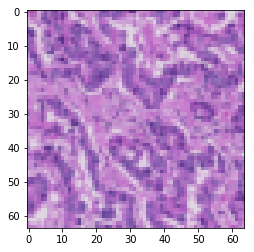

In [39]:
plt.imshow(np.array(X_train[0],dtype="uint8"))
Train_data.loc[Train_data.index[0],"label"]

In [40]:
# Taken from http://stackoverflow.com/questions/29831489/numpy-1-hot-array
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='float32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [41]:
Y_train=convertToOneHot(Y_train,num_classes=2)
Y_val=convertToOneHot(Y_val,num_classes=2)

### save as hdf5

In [42]:
import h5py
h5f = h5py.File('/notebooks/local/Patho_Poster_DLD_2017/Train_1.hdf5', 'w')
h5f.create_dataset('X_train', data=X_train)
h5f.create_dataset('Y_train', data=Y_train)
h5f.close()

h5f = h5py.File('/notebooks/local/Patho_Poster_DLD_2017/Val1.hdf5', 'w')
h5f.create_dataset('X_val', data=X_val)
h5f.create_dataset('Y_val', data=Y_val)
h5f.close()


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
import h5py
hf = h5py.File('/notebooks/local/Patho_Poster_DLD_2017/Train_1.hdf5', 'r')
print(list(hf.keys()))
X_train = hf.get('X_train')
Y_train = hf.get('Y_train')

['X_train', 'Y_train']


In [45]:
hf = h5py.File('/notebooks/local/Patho_Poster_DLD_2017/Val1.hdf5', 'r')
print(list(hf.keys()))
X_val = hf.get('X_val')
Y_val = hf.get('Y_val')

['X_val', 'Y_val']
